In [1429]:
# Necessary libraries for analysis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import miceforest as mf
import scipy.stats as stats
import statsmodels.api as sm   


# Principal Component Analysis
#==================================================================

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA


# Factorial Analysis
#==================================================================

from factor_analyzer import FactorAnalyzer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale


# Test and train split
#==================================================================

from sklearn.model_selection import train_test_split


# Warnings settings
#=================================================================
import warnings
warnings.filterwarnings("ignore") 



### Importar datos

In [1430]:
data = pd.read_csv(r"Employees.csv")
print(data.shape)
data.head(3)


(7000, 17)


,Employee_ID,Gender,Age,Education_Level,Relationship_Status,Hometown,Unit,Decision_skill_possess,Time_of_service,Time_since_promotion,growth_rate,Travel_Rate,Post_Level,Pay_Scale,Compensation_and_Benefits,Work_Life_balance,Attrition_rate
0,EID_23371,F,42.0,4,Married,Franklin,IT,Conceptual,4.0,4,33,1,1,7.0,type2,3.0,0.1841
1,EID_18000,M,24.0,3,Single,Springfield,Logistics,Analytical,5.0,4,36,0,3,6.0,type2,4.0,0.0670
2,EID_3891,F,58.0,3,Married,Clinton,Quality,Conceptual,27.0,3,51,0,2,8.0,type2,1.0,0.0851


#### Análisis exploratorio de datos

In [1431]:
# Data dimension

data_dim = data.shape


In [1432]:
# Tipos de variables y número de variables por tipo
variable_types = pd.DataFrame(data.dtypes.value_counts())
variable_types.set_axis(['Variables'],axis=1,inplace=True)
variable_types

print("El set de datos a trabajar tiene un tamaño", data_dim,
    "\nLos tipos de variables con los que se cuenta son 'object', 'float64' e 'int64', es decir, se cuenta",
    "con variables del tipo numérico (continuas y discretas) y de variables de texto.")

El set de datos a trabajar tiene un tamaño (7000, 17) 
Los tipos de variables con los que se cuenta son 'object', 'float64' e 'int64', es decir, se cuenta con variables del tipo numérico (continuas y discretas) y de variables de texto.


In [1433]:
# Detectar columnas con valores perdidos y número de valores perdidos por columna

data_types = pd.DataFrame(data.dtypes) # Crea un datafaframe de las variables y su tipo
data_missing_values = pd.DataFrame(data.isna().sum()) # Crea un dataframe con valores perdidos por variable
data_missing_variables = pd.concat([data_missing_values,data_types],axis=1) # Concatena valores perdidos con tipo de variable por variable
data_missing_variables.set_axis(['Missing values','Data type'],axis=1,inplace=True) # Set col names n = numero de valores perdidos, type = tipo de datos
data_missing_variables = data_missing_variables[data_missing_variables['Missing values'] != 0] # Filtrar variables para obtener campos con datos perdidos ()
missing_variabes = data_missing_variables.index

print("Existen",data_missing_variables.shape[0],"campos o variables con valores fatantes, las cuáles se muestran en la siguiente tabla:")
print("\n",data_missing_variables,"\n\nSe observa que todas las variables que presentan valores perdidos son del tipo numérico")

Existen 4 campos o variables con valores fatantes, las cuáles se muestran en la siguiente tabla:

                    Missing values Data type
Age                           412   float64
Time_of_service               144   float64
Pay_Scale                       9   float64
Work_Life_balance              11   float64 

Se observa que todas las variables que presentan valores perdidos son del tipo numérico


In [1434]:
# Crear listas de variables por tipos de datos

int_variables = (data_types[data_types[0] == 'int64'].T).columns # Filtra el dataframe para obtener sólo las de tipo int64, traspone el dataframe y extrae las columnas para crear una lista
float_variables = (data_types[data_types[0] == 'float64'].T).columns
obj_variables = (data_types[data_types[0] == 'object'].T).columns

In [1435]:
# Crear listas de variables por tipos de datos


#Categóricas Nominales
nom_variables = ['Employee_ID','Gender','Relationship_Status']
#Categóricas Ordinales
ord_variables = ['Education_Level','Travel_Rate','Post_Level','Pay_Scale','Work_Life_balance','Compensation_and_Benefits']
#Contínuas
num_variables = ['Age','Time_of_service','Time_since_promotion','growth_rate','Attrition_rate']
#Categóricas Nominales (One Hot Encoding)
ohe_variables = ['Hometown','Unit','Decision_skill_possess']

#nom,ord,num,ohe

In [1436]:
# Crear datasets para cada tipo de datos y realizar limpieza de los datos por separado

df_nom = data[nom_variables]
df_ord = data[ord_variables]
df_num = data[num_variables]
df_ohe = data[ohe_variables]

### Tratamiento de datos perdidos

#### Imputación de variables contínuas

Las valores faltantes de las variables tipo numérica contínuas se han de imputar utilizando una técnica de imputación múltiple, por otro lado, los datos faltantes de variables numéricas disctretas se imputarán utilizando la moda, ya que este es el método generalmente aceptado y más utilizado para este tipo de datos.

In [1437]:
df_num.isna().sum()

Age                     412
Time_of_service         144
Time_since_promotion      0
growth_rate               0
Attrition_rate            0
dtype: int64

              Class: ImputationKernel
           Datasets: 4
         Iterations: 2
  Imputed Variables: 2
save_all_iterations: True


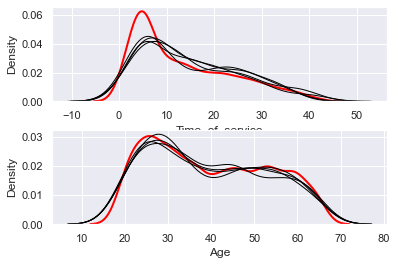

In [1438]:
# Multiple Imputation for Continuous Data
# Select dataset
df_num_mice = df_num

# Create kernel. 
kernel = mf.ImputationKernel(
  df_num_mice,
  datasets=4,
  save_all_iterations=True,
  random_state=1
)

# Run the MICE algorithm for 2 iterations on each of the datasets
kernel.mice(2)

# Distribution of imputed values 

kernel.plot_imputed_distributions(wspace=0.3,hspace=0.3)

# Printing the kernel will show you some high level information.
print(kernel)

# Select dataset with imputated data
df_num_mice = kernel.complete_data(0)
df_num = df_num_mice

In [1439]:
print("Se han imputado valores faltantes de las variables 'Time_of_service' y 'Age' \n",)
df_num.isna().sum()

Se han imputado valores faltantes de las variables 'Time_of_service' y 'Age' 



Age                     0
Time_of_service         0
Time_since_promotion    0
growth_rate             0
Attrition_rate          0
dtype: int64

#### Imputación de variables discretas

In [1440]:
df_ord.isna().sum()

Education_Level               0
Travel_Rate                   0
Post_Level                    0
Pay_Scale                     9
Work_Life_balance            11
Compensation_and_Benefits     0
dtype: int64

In [1441]:
# Imputation using mode() for Categorical Data

df_ord['Pay_Scale'].fillna(df_ord['Pay_Scale'].mode()[0], inplace=True)
df_ord['Work_Life_balance'].fillna(df_ord['Work_Life_balance'].mode()[0], inplace=True)
print("Se han imputado valores faltantes de las variables 'Pay_Scale' y 'Work_Life_balance' \n",)
df_ord.isna().sum()


Se han imputado valores faltantes de las variables 'Pay_Scale' y 'Work_Life_balance' 



Education_Level              0
Travel_Rate                  0
Post_Level                   0
Pay_Scale                    0
Work_Life_balance            0
Compensation_and_Benefits    0
dtype: int64

In [1442]:
# Definir variables a trabajar y crear un dataset

dataset = pd.concat([df_num,df_ohe],axis=1)
print("Los sets de datos de variables numéricas se concatenan para continuar con el análisis")
dataset.isna().sum()

Los sets de datos de variables numéricas se concatenan para continuar con el análisis


Age                       0
Time_of_service           0
Time_since_promotion      0
growth_rate               0
Attrition_rate            0
Hometown                  0
Unit                      0
Decision_skill_possess    0
dtype: int64

### One Hot enoding 

Las variables que han sido consideradas para este procedimiento son las variables categóricas del tipo nominal. De estás se han seleccionado solamente las que presentan más de dos valores.

In [1443]:
df_ohe.columns

Index(['Hometown', 'Unit', 'Decision_skill_possess'], dtype='object')

In [1444]:
# One Hot Encoding
dataset = pd.get_dummies(dataset,columns=['Hometown'])
dataset = pd.get_dummies(dataset,columns=['Unit'])
dataset = pd.get_dummies(dataset,columns=['Decision_skill_possess'])

In [1445]:
dataset.head()

,Age,Time_of_service,Time_since_promotion,growth_rate,Attrition_rate,Hometown_Clinton,Hometown_Franklin,Hometown_Lebanon,Hometown_Springfield,Hometown_Washington,...,Unit_Production,Unit_Purchasing,Unit_Quality,Unit_R&D,Unit_Sales,Unit_Security,Decision_skill_possess_Analytical,Decision_skill_possess_Behavioral,Decision_skill_possess_Conceptual,Decision_skill_possess_Directive
0,42.0,4.0,4,33,0.1841,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,24.0,5.0,4,36,0.0670,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
2,58.0,27.0,3,51,0.0851,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
3,26.0,4.0,3,56,0.0668,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,31.0,5.0,4,62,0.1827,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


## Principal Component Analysis

In [1446]:
dfk = dataset
p_vars = dfk.shape[1] # Numero de variables del set de datos
pca_model = PCA(n_components = p_vars) 

In [1447]:
# Crear lista de etiquetas de componentes principales

princomp = pd.DataFrame(index=[list(range(0,p_vars))])
princomp['P_C'] = "PC"
princomp['P_n'] = list(range(1,p_vars+1))
princomp['num'] = princomp['P_n'].astype(str)
princomp['P_C_N'] = princomp['P_C'].str.cat(princomp['num'],sep="") 
P_C_N= princomp['P_C_N'].to_list()


#### Data scaling

In [1448]:
# Escalamiento de los datos

scaler = StandardScaler()
dfk_s = scaler.fit(dfk) # Recordemos que dfk es el datframe de valores numéricas al cuál se le han imputado los valores perdidos
dfk_s = scaler.transform(dfk)

In [1449]:
# Perform PCA

pca_model.fit(dfk_s) 

PCA(n_components=26)

#### Loadings

In [1450]:
# Ver las cargas de cada componente principal ordenadas para observar su influencia en cada pc

prince_of_persia = pd.DataFrame(
    data    = pca_model.components_,
    columns = dfk.columns,
    index   = P_C_N
)
pop = pd.DataFrame(prince_of_persia.T)
#pop['PC1'].sort_values(kind="quicksort")

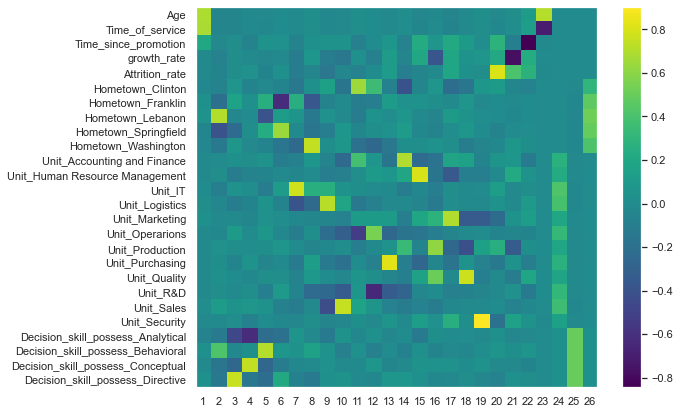

In [1451]:
# Heatmap de componentes principales

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 7))
components = pca_model.components_
plt.imshow(components.T, cmap='viridis', aspect='auto')
plt.yticks(range(len(dfk.columns)), dfk.columns)
plt.xticks(range(len(dfk.columns)), np.arange(pca_model.n_components_) + 1)
plt.grid(False)
plt.colorbar();

#### Number of components

Cummulative Explainef Variance
[0.07586457 0.13015805 0.18203974 0.23368102 0.2846716  0.33495018
 0.38230625 0.42942937 0.47491846 0.51871503 0.56189947 0.60399441
 0.64543983 0.68645544 0.72710124 0.76740243 0.80709812 0.8464854
 0.88574654 0.92402816 0.9612177  0.99690421 1.         1.
 1.         1.        ]

 Se observa que con 16 componentes se logra cumplir con el 75% de varianza explicada, que es el mínimo aceptable, y son necesarios 22 componentes para cubrir el 100% de la variación explicada


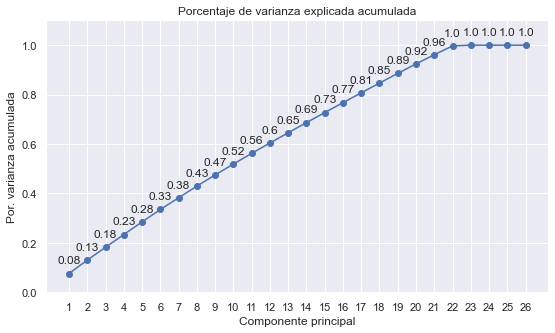

In [1452]:
# Porcentaje de varianza explicada acumulada

# Porcentaje de varianza explicada
s_cum_prop = pca_model.explained_variance_ratio_.cumsum()

print('Cummulative Explainef Variance')
print(s_cum_prop)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,5))
ax.plot(
    np.arange(len(dfk.columns)) + 1,
    s_cum_prop,
    marker = 'o'
)

for x, y in zip(np.arange(len(dfk.columns)) + 1, s_cum_prop):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )
    
ax.set_ylim(0, 1.1)
ax.set_xticks(np.arange(pca_model.n_components_) + 1)
ax.set_title('Porcentaje de varianza explicada acumulada')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza acumulada')

print("\n Se observa que con 16 componentes se logra cumplir con el 75% de varianza explicada, que es el",
    "mínimo aceptable, y son necesarios 22 componentes para cubrir el 100% de la variación explicada")


In [1453]:
# Definir el número de Componentes principales

s_change =  0.05 # Cambio mínimo en la vairanza acumulada para definir nro de componentes
s_explained = 0.85 # Mínimo de varianza explicada Aceptable = (85%, 95%), Mínimo = 75%
s_cum = round(pd.DataFrame(s_cum_prop),2) #df de la varianza acumulada
s_cum.set_axis(['S'],axis=1,inplace=True) # Renombrar columna

s_cum = s_cum[s_cum['S'] > s_explained] # Filtrar los casos con variación explicada mayor a 0.85
n_comp = s_cum.index[:1].values # Obtener el índice 
n_comp = n_comp[0] # El índice es igual a el número de componentes a utilizar

print("Siguiendo el pricipio de reducir el máximo posible de dimensiones o de información se ha utilizado el 85% de varianza explicada acumulada, que es considerado aceptable, como criterio para elegir el número de componentes a utilizar, siendo este", n_comp)

Siguiendo el pricipio de reducir el máximo posible de dimensiones o de información se ha utilizado el 85% de varianza explicada acumulada, que es considerado aceptable, como criterio para elegir el número de componentes a utilizar, siendo este 18


In [1454]:
# Proyecciones

projections = np.dot(pca_model.components_, scale(dfk).T)
projections = pd.DataFrame(projections, index = P_C_N)
projections = projections.transpose().set_index(dfk.index)
projections.head(3)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26
0,-0.133332,-1.062408,0.002729,1.745344,-0.106643,-1.422773,2.462352,-0.276213,0.752161,0.215553,...,0.301276,0.266624,-0.002777,0.506375,0.427474,-1.591992,0.754415,3.476509e-16,-4.941765e-16,-2.220446e-16
1,-1.219200,-1.202876,-1.795104,-1.639101,0.389442,0.902345,-0.912266,-1.038139,1.711172,0.969162,...,0.216652,0.313870,-0.163846,-0.175602,-0.000357,-1.576524,-0.241290,-4.086886e-16,2.274685e-16,4.440892e-16
2,1.790764,-0.568488,-0.405478,1.237154,-0.581359,-0.354307,-1.060376,0.788111,0.649797,-0.932072,...,-0.860403,4.156282,-0.064762,-0.063093,-1.267570,0.540917,0.069636,8.472512e-16,-1.160310e-15,3.330669e-16


In [1455]:
# Crear el set de datos definitivo
# Número y lista de componentes a utilizar
P_C_N = princomp['P_C_N']
P_C_N = P_C_N[0:n_comp].to_list()
#P_C_N

df_pc = projections[P_C_N]
df_pc = pd.concat([df_nom,df_ord,df_pc],axis=1)
df_pc.to_csv(r"dataset_pca.csv")
df_pc.head()

,Employee_ID,Gender,Relationship_Status,Education_Level,Travel_Rate,Post_Level,Pay_Scale,Work_Life_balance,Compensation_and_Benefits,PC1,...,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18
0,EID_23371,F,Married,4,1,1,7.0,3.0,type2,-0.133332,...,0.752161,0.215553,-0.313683,0.028859,0.176309,-0.263471,0.364979,0.418897,0.301276,0.266624
1,EID_18000,M,Single,3,0,3,6.0,4.0,type2,-1.219200,...,1.711172,0.969162,-0.646788,-0.029895,-0.046954,0.200623,-0.165887,-0.007915,0.216652,0.313870
2,EID_3891,F,Married,3,0,2,8.0,1.0,type2,1.790764,...,0.649797,-0.932072,2.843755,1.620028,-0.733549,-2.029639,1.029295,3.481566,-0.860403,4.156282
3,EID_17492,F,Single,3,1,3,8.0,1.0,type2,-1.060956,...,-0.148861,-0.644480,-0.028163,0.374335,0.439469,0.815483,4.108197,-1.105276,-1.270350,-0.330410
4,EID_22534,F,Married,1,1,3,2.0,3.0,type3,-0.767778,...,1.779213,0.547187,-0.570259,-0.067298,0.183180,0.044899,0.502689,-0.582181,0.718494,0.388778


## Factorial Analysis

#### Adequacy Test

Según los criterios para evaluar la factorabilidad (factorability) de nuestros datos, i.e., que sea posible encontrar factores en nuestro dataset, el Análisis Factorial no resulta ser adecuado. Se ha llevado a cabo el análisis para complir obtener el set de datos solicitado en los entregables de este reto.

##### Bartlett’s test 
Signifficance when p_Value < 0.05

In [1456]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
chi_square_value,p_value=calculate_bartlett_sphericity(dfk)
chi_square_value, p_value

if p_value < 0.05:
    print("p-Value:",round(p_value,2),"The test was statistically significant, the observed correlation matrix is not an identity matri. You can proced to FA")
else: print("You should not use Factorial Analysis.")


You should not use Factorial Analysis.


##### KMO

KMO values range between 0 and 1. Value of KMO less than 0.6 is considered inadequate.

In [1457]:
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all,kmo_model=calculate_kmo(dfk)

if kmo_model > 0.6:
    print("FA is apropiate for your data, you can proceed with your planned factor analysis.")
else:
    print("KMO:",round(kmo_model,2),"FA is not a good approach for your data")

KMO: 0.48 FA is not a good approach for your data


#### Data Scaling

In [1458]:
from factor_analyzer import FactorAnalyzer

In [1459]:
scaler = StandardScaler()
dfk = dataset
dfk_s = scaler.fit(dfk) # Recordemos que dfk es el datframe de valores numéricas al cuál se le han imputado los valores perdidos
dfk_s = scaler.transform(dfk)

#### Number of factors

In [1460]:
# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer()
fa.fit(dfk_s)
# Check Eigenvalues
ev, v = fa.get_eigenvalues()
nfa = pd.DataFrame(ev)
nfa = nfa[nfa[0] > 1]
nfa = nfa.index.max()
nfa

18

In [1461]:
fa = FactorAnalyzer(n_factors=nfa)
fa.fit(dfk_s)

FactorAnalyzer(n_factors=18, rotation_kwargs={})

In [1462]:
pd.DataFrame(fa.loadings_)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.052311,0.032358,0.021803,1.026152,-0.020682,0.002597,0.061037,0.021799,0.041791,0.061371,0.057935,0.023238,0.001947,-0.027230,-0.042262,0.023561,-0.043023,-0.001173
1,0.057126,0.030282,0.018081,0.948388,-0.012243,0.005044,0.061842,0.027535,0.034174,0.054001,0.056698,0.019988,-0.001172,-0.031018,-0.040107,0.020317,-0.032173,-0.009523
2,-0.011782,-0.001041,0.002149,0.149248,0.001383,-0.010147,-0.007049,-0.008627,-0.017143,-0.013469,-0.012926,-0.016089,0.001476,0.005955,0.016616,-0.008732,0.011676,0.002406
3,0.011433,0.015710,0.002087,0.000187,0.006871,-0.001095,0.008145,-0.019667,0.010397,0.005255,-0.002019,-0.004549,-0.000499,0.016084,0.002273,0.002938,-0.005610,0.022929
4,0.009117,0.011517,0.012747,-0.008512,-0.007735,-0.010178,0.019146,0.003373,-0.004505,0.005179,0.009897,-0.008626,0.002188,-0.006372,0.002226,-0.002072,-0.000408,-0.003787
5,-0.009467,-0.007046,0.007156,-0.000906,-0.012146,0.150221,-0.002926,0.202347,-0.019790,-0.008461,0.007997,-0.008379,0.182698,-0.016590,0.006040,1.090392,0.010062,-0.021203
6,0.014505,0.018207,0.015255,-0.007994,-0.007250,0.232530,0.018684,0.279624,-0.001184,0.006316,0.012316,-0.012725,-1.094645,-0.000752,0.004579,-0.177847,-0.002007,0.002569
7,0.060426,0.080253,0.030344,-0.017987,0.017762,0.578937,0.064742,0.304422,0.031102,0.034731,0.003938,-0.039967,0.424969,0.052877,0.017025,-0.192193,-0.024406,0.080205
8,-0.032516,-0.042460,-0.047615,0.030801,0.031147,-1.114102,-0.057075,0.282720,0.021346,-0.017975,-0.040372,0.039173,0.275714,0.024181,-0.013082,-0.171017,-0.000477,0.014606
9,-0.046445,-0.065474,-0.004190,-0.004244,-0.041829,0.219502,-0.032380,-1.183058,-0.048070,-0.023000,0.022968,0.024279,0.243653,-0.081551,-0.015503,-0.170192,0.025856,-0.104716


#### Loadings

In [1463]:
fantastic_beasts = pd.DataFrame ( 
    data = fa.loadings_,
    columns = ['Factor 1', 'Factor 2','Factor 3','Factor 4', 'Factor 5','Factor 6','Factor 7', 'Factor 8','Factor 9','Factor 10', 'Factor 11','Factor 12','Factor 13', 'Factor 14','Factor 15','Factor 16', 'Factor 17','Factor 18'],
    index = dfk.columns
)

fantastic_beasts

,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6,Factor 7,Factor 8,Factor 9,Factor 10,Factor 11,Factor 12,Factor 13,Factor 14,Factor 15,Factor 16,Factor 17,Factor 18
Age,0.052311,0.032358,0.021803,1.026152,-0.020682,0.002597,0.061037,0.021799,0.041791,0.061371,0.057935,0.023238,0.001947,-0.027230,-0.042262,0.023561,-0.043023,-0.001173
Time_of_service,0.057126,0.030282,0.018081,0.948388,-0.012243,0.005044,0.061842,0.027535,0.034174,0.054001,0.056698,0.019988,-0.001172,-0.031018,-0.040107,0.020317,-0.032173,-0.009523
Time_since_promotion,-0.011782,-0.001041,0.002149,0.149248,0.001383,-0.010147,-0.007049,-0.008627,-0.017143,-0.013469,-0.012926,-0.016089,0.001476,0.005955,0.016616,-0.008732,0.011676,0.002406
growth_rate,0.011433,0.015710,0.002087,0.000187,0.006871,-0.001095,0.008145,-0.019667,0.010397,0.005255,-0.002019,-0.004549,-0.000499,0.016084,0.002273,0.002938,-0.005610,0.022929
Attrition_rate,0.009117,0.011517,0.012747,-0.008512,-0.007735,-0.010178,0.019146,0.003373,-0.004505,0.005179,0.009897,-0.008626,0.002188,-0.006372,0.002226,-0.002072,-0.000408,-0.003787
Hometown_Clinton,-0.009467,-0.007046,0.007156,-0.000906,-0.012146,0.150221,-0.002926,0.202347,-0.019790,-0.008461,0.007997,-0.008379,0.182698,-0.016590,0.006040,1.090392,0.010062,-0.021203
Hometown_Franklin,0.014505,0.018207,0.015255,-0.007994,-0.007250,0.232530,0.018684,0.279624,-0.001184,0.006316,0.012316,-0.012725,-1.094645,-0.000752,0.004579,-0.177847,-0.002007,0.002569
Hometown_Lebanon,0.060426,0.080253,0.030344,-0.017987,0.017762,0.578937,0.064742,0.304422,0.031102,0.034731,0.003938,-0.039967,0.424969,0.052877,0.017025,-0.192193,-0.024406,0.080205
Hometown_Springfield,-0.032516,-0.042460,-0.047615,0.030801,0.031147,-1.114102,-0.057075,0.282720,0.021346,-0.017975,-0.040372,0.039173,0.275714,0.024181,-0.013082,-0.171017,-0.000477,0.014606
Hometown_Washington,-0.046445,-0.065474,-0.004190,-0.004244,-0.041829,0.219502,-0.032380,-1.183058,-0.048070,-0.023000,0.022968,0.024279,0.243653,-0.081551,-0.015503,-0.170192,0.025856,-0.104716


#### Cummulative Variance

In [1464]:
fa.get_factor_variance()[2]

array([0.08699307, 0.17262021, 0.25518449, 0.33190977, 0.40539578,
       0.47178889, 0.53791083, 0.60389759, 0.6656718 , 0.72665715,
       0.7867182 , 0.84658226, 0.90614924, 0.9639472 , 1.01465955,
       1.0653592 , 1.10920781, 1.12522539])

In [1465]:
df_fa = pd.DataFrame(fa.transform(dfk_s))
df_fa.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,-1.149167,-1.048139,-1.193140,0.061660,1.342089,0.225933,0.029267,0.156020,-1.089949,1.527611,1.324283,0.316548,-1.665405,-0.994964,-0.897726,-0.054119,-0.788796,0.799381
1,-0.174557,-0.167523,-0.124292,-1.002592,0.089129,-1.323627,0.942353,0.328872,-0.225447,-1.801460,-1.147976,1.181783,0.303345,-0.214447,-0.086325,-0.214519,0.014000,-0.874447
2,-0.086667,-0.079389,-0.091578,1.411331,0.071093,0.054058,0.076142,-0.027573,-0.023542,-0.001686,1.379947,0.228658,-0.024780,0.008942,-0.012960,3.055256,5.525657,1.236881


In [1466]:
df_fa = pd.concat([df_nom,df_ord,df_fa],axis=1)
df_fa.to_csv(r"dataset_fa.csv")
df_fa.head(3)

,Employee_ID,Gender,Relationship_Status,Education_Level,Travel_Rate,Post_Level,Pay_Scale,Work_Life_balance,Compensation_and_Benefits,0,...,8,9,10,11,12,13,14,15,16,17
0,EID_23371,F,Married,4,1,1,7.0,3.0,type2,-1.149167,...,-1.089949,1.527611,1.324283,0.316548,-1.665405,-0.994964,-0.897726,-0.054119,-0.788796,0.799381
1,EID_18000,M,Single,3,0,3,6.0,4.0,type2,-0.174557,...,-0.225447,-1.801460,-1.147976,1.181783,0.303345,-0.214447,-0.086325,-0.214519,0.014000,-0.874447
2,EID_3891,F,Married,3,0,2,8.0,1.0,type2,-0.086667,...,-0.023542,-0.001686,1.379947,0.228658,-0.024780,0.008942,-0.012960,3.055256,5.525657,1.236881
